In [ ]:
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null
!pip install wandb -U >> /dev/null

ERROR: Invalid requirement: '{tsai -U'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null
from tsai.all import *
computer_setup()

Mounted at /content/drive
os              : Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
python          : 3.7.15
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
wandb           : 0.13.5
torch           : 1.12.1+cu113
device          : 1 gpu (['Tesla T4'])
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : [14.75] GB
os              : Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
python          : 3.7.15
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.12.1+cu113
device          : 1 gpu (['Tesla T4'])
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : [14.75] GB


In [ ]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'tsaiV1'

In [ ]:
wandb.login()

wandb: Currently logged in as: emilemolewijk. Use `wandb login --relogin` to force relogin


True

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch      

In [ ]:
# data is csv 
data = np.genfromtxt('/content/drive/MyDrive/digitalTwin_data/data_dump_training_V1.csv', delimiter=',')

In [ ]:
data.shape

(197230, 8)

In [ ]:
# min rij 1 en col 1 (index and headers)
data = data[1:,:]
data = data[:,1:]

In [ ]:
# kijk of headers weg zijn 
data[0,:]

array([3.29411779e-01, 2.14602493e+02, 9.63256806e-02, 1.16184488e-01,
       1.20849633e+00, 5.42952299e-01, 5.54001153e-01])

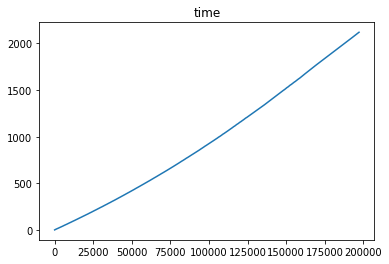

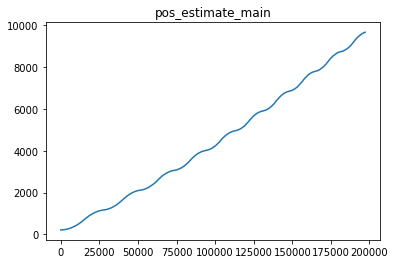

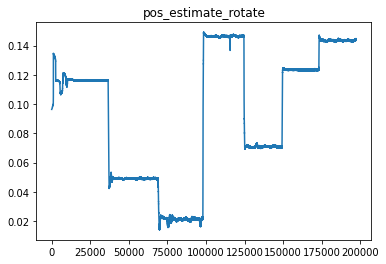

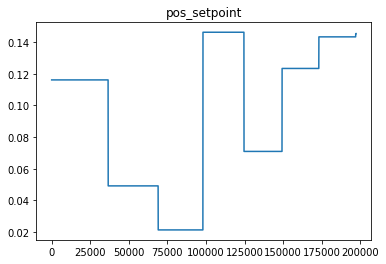

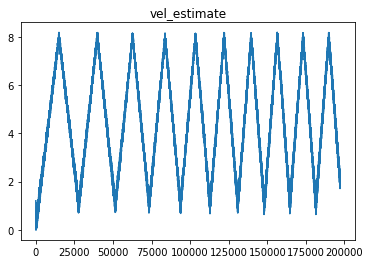

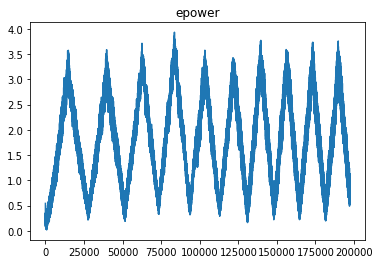

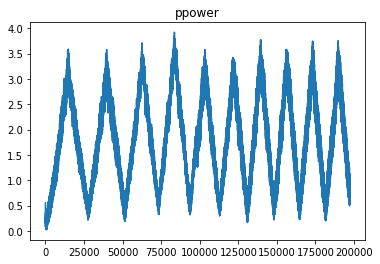

In [ ]:
# print data 
name = ['time','pos_estimate_main','pos_estimate_rotate','pos_setpoint','vel_estimate','epower','ppower']
for i in range(7):
  plt.plot(data[:,i])
  plt.title(label=name[i])
  plt.show()


(197229, 5)

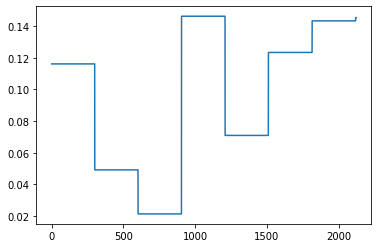

In [ ]:
# y = label = de setpoint position
y = data[:,3]
plt.plot(data[:,0],y)
# x = coloms for the ai (data motor 1 plus time)
X = data[:,[0,1,4,5,6]]
X.shape

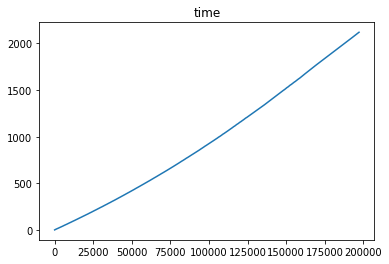

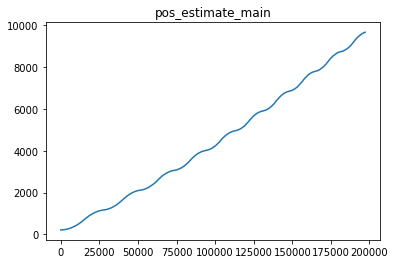

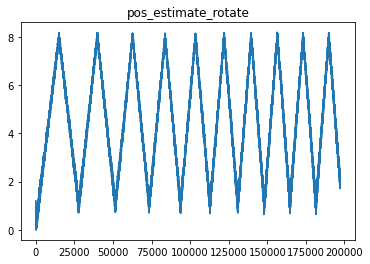

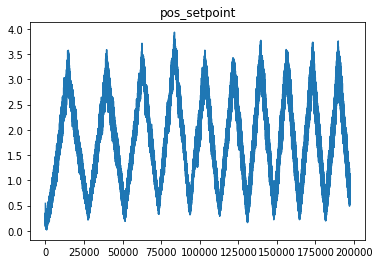

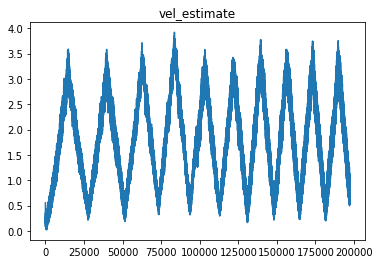

In [ ]:
# plot x coloms
for i in range(5):
  plt.plot(X[:,i])
  plt.title(label=name[i])
  plt.show()

In [ ]:
window = 300

sample_size = math.floor(len(X)/window)

print(sample_size,len(X)/window)

657 657.43


In [ ]:
# limit X to max time window
X3 = X[0:sample_size*window,:]

X.shape,X3.shape

((197229, 5), (197100, 5))

In [ ]:
# x1 = cut data into samples of lengt window (+-window/300 sec)
# Y1 = labels based on te first position of theplatform
X1 = np.zeros((sample_size, 5, window))
Y1 = np.zeros(sample_size)
for i in range(sample_size):
  X1[i,:,:] = X3[i*window:(i+1)*window,:].T
  Y1[i] = data[i*window,3]

In [ ]:
#X2 = np.reshape(X3, (3000,5,65))

In [ ]:
X1.shape

(657, 5, 300)

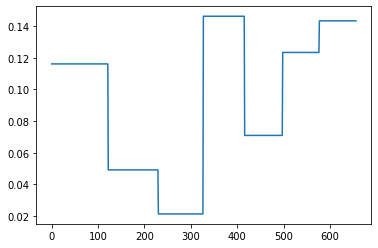

In [ ]:
plt.plot(Y1)

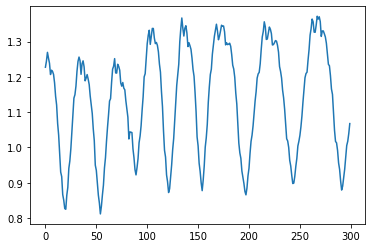

In [ ]:
# sample 20 colom 4 all (lengt is 3000)
plt.plot(X1[20,4,:])

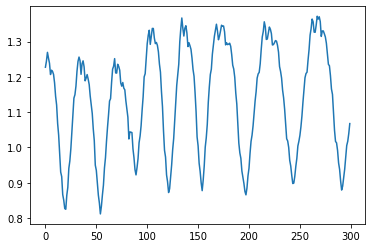

In [ ]:
# kijk of het knippen goed is gegaan
plt.plot(X3[window*20:window*(20+1),4])

In [ ]:
# folgens het format van tsai moet 
# Y = (65,) vactor
# X = (65, 5, 3000) is (sample,variables,lengt_samples)
X1.shape, Y1.shape

((657, 5, 300), (657,))

In [ ]:
# split to train and test
X_train = X1[1:(sample_size-1):2,:,:]
X_test = X1[0:sample_size:2,:,:]

y_train = Y1[1:(sample_size-1):2]
y_test = Y1[0:sample_size:2]



In [ ]:

X_train = X1[0:sample_size-100,2,:]
X_test = X1[sample_size-100:,2,:]

y_train = Y1[0:sample_size-100]
y_test = Y1[sample_size-100:]

In [ ]:
#X_train1, y_train1, X_valid1, y_valid1 = np.random.rand(3,3,4), np.random.randint(0,2,3), np.random.rand(2,3,4), np.random.randint(0,2,2)


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((557, 300), (557,), (100, 300), (100,))

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((557, 300), (557,), (100, 300), (100,))

In [ ]:
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

In [ ]:
#maakt y catagories
#tfms  = [None, [Categorize()]]
# maakt fast2 dataset aan
dsets = TSDatasets(X, y, splits=splits, inplace=True)

In [ ]:
#dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128],batch_tfms=[TSStandardize()],num_workers=0)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128],batch_tfms=[Normalize.from_stats(mean = 0, std=100)],num_workers=0)


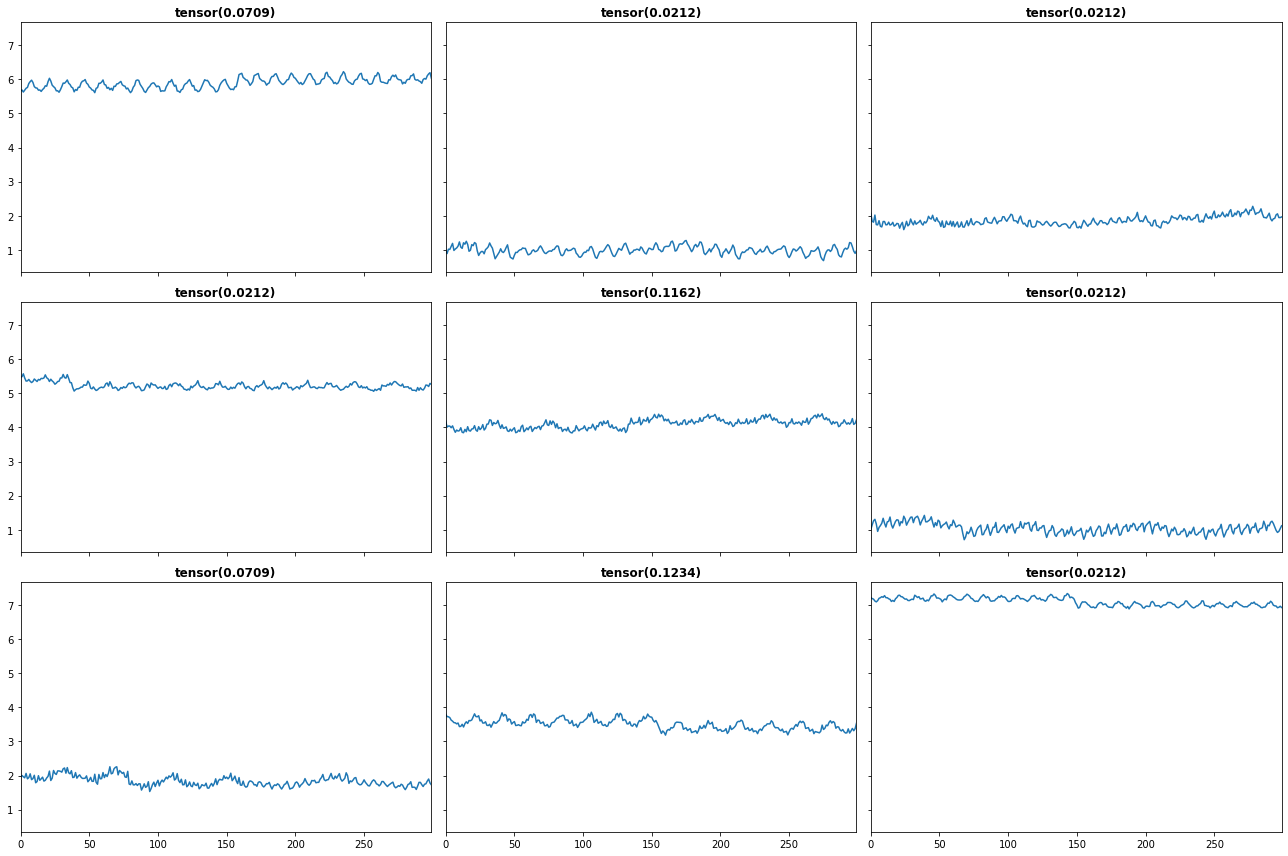

In [ ]:
dls.show_batch(sharey=True)

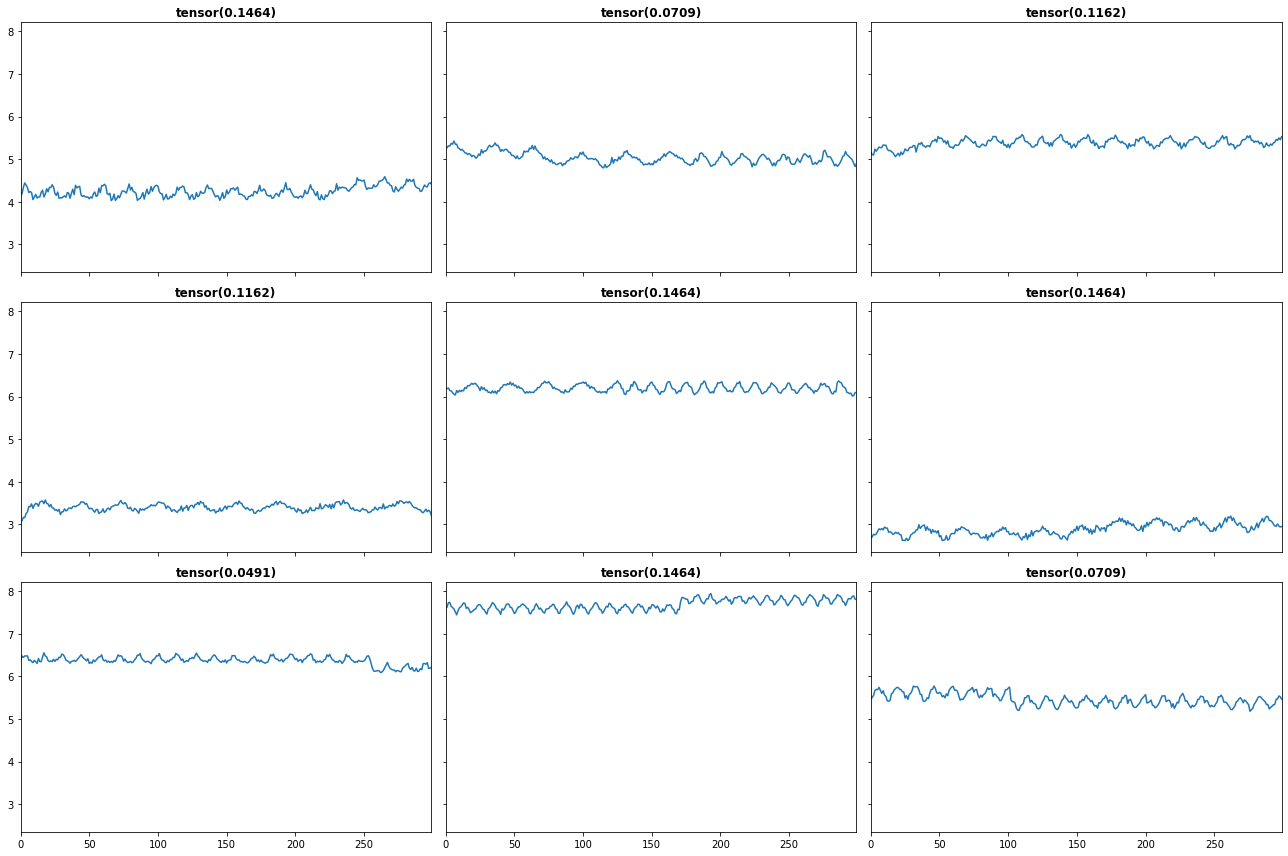

In [ ]:
dls.show_batch(sharey=True)

In [ ]:
config = AttrDict (
    batch_tfms = TSStandardize(by_sample=True),
    arch_config = {},
    architecture = TSiTPlus,
    lr = 1e-3,
    n_epoch = 10,   
)
# model = InceptionTime(dls.vars, dls.c)
model = MiniRocket(dls.vars, dls.c,seq_len = window)
learn = Learner(dls, model, metrics=accuracy,loss_func = torch.nn.L1Loss())
learn.save('stage0')


Path('models/stage0.pth')

In [ ]:
#learn.load('minirocket_stage0')
learn.lr_find()

In [ ]:
#learn.load('minirocket_stage0')
learn.fit_one_cycle(15, lr_max=10e-4)
learn.save('minirocket_stage1')

epoch,train_loss,valid_loss,accuracy,time
0,0.095904,0.103015,0.000000,00:13
1,0.128564,0.049311,0.000000,00:13
2,0.161990,0.189493,0.000000,00:13
3,0.217487,0.121130,0.000000,00:13
4,0.232518,0.101769,0.000000,00:14
5,0.243760,0.671171,0.000000,00:13
6,0.282450,0.757348,0.000000,00:13
7,0.287413,0.197578,0.000000,00:13
8,0.284887,0.177787,0.000000,00:13
9,0.264782,0.228355,0.000000,00:13


Path('models/minirocket_stage1.pth')

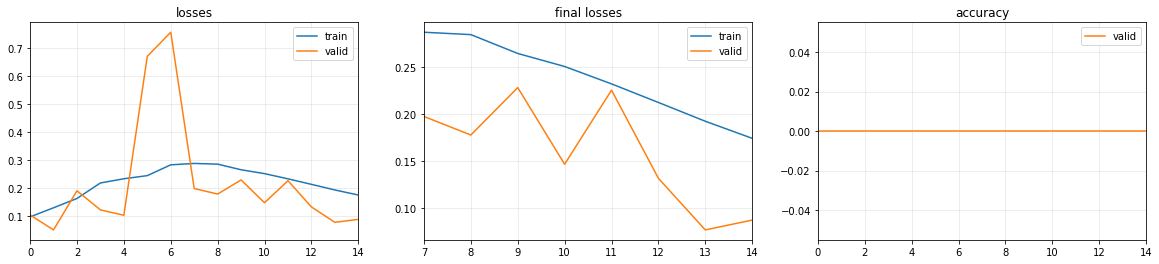

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
#plt.plot(b[1])
#plt.show()
#plt.plot(y_test[0:128])
#plt.show()
#plt.plot((torch.from_numpy(y_test[0:128])-b[1]))
#plt.show()
#b,y_test

In [ ]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
#valid_probas, valid_targets, valid_preds
g = valid_targets-valid_preds

In [ ]:
g

In [ ]:
valid_targets[0:5],valid_preds[0:5]

In [ ]:
learn.show_results()

In [ ]:
learn.show_probas()